## Libraries

In [ ]:
# # Install Libraries
# %%capture
# !pip install streamlit pyngrok

In [ ]:
#importing libraries
from fastai import *
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## CNN

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
%%capture
!pip install pyro-ppl

In [ ]:
import torch
import pyro
import pyro.distributions as dist
import pyro.contrib.bnn as bnn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision

In [ ]:
class_n = {}
for i, folder in enumerate(os.listdir('/content/drive/MyDrive/COLAB/DATASETS/Raphina AI/Wound_Data/Test')):
  class_n[i] = folder

In [ ]:
# Define a custom dataset class
class WoundDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.img_paths = []
        self.labels = []

        # Iterate through the folders and append the image paths and labels
        for i, folder in enumerate(os.listdir(data_path)):
            folder_path = os.path.join(data_path, folder)
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                self.img_paths.append(img_path)
                self.labels.append(i)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [ ]:
# Define the transforms for the dataset
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])


# Define the dataset and dataloaders
train_ = WoundDataset('/content/drive/MyDrive/COLAB/DATASETS/Raphina AI/Wound_Data/Train', transform=train_transforms)
train = DataLoader(train_, batch_size=32, shuffle=True)

valid_ = WoundDataset('/content/drive/MyDrive/COLAB/DATASETS/Raphina AI/Wound_Data/Valid', transform=train_transforms)
valid = DataLoader(valid_, batch_size=32, shuffle=True)

In [ ]:
def fit(train_dl, val_dl, model, opt, criterion, scheduler, n_epochs=10):
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.
        train_acc = 0.
        for x, y in train_dl:
            x, y = x.cuda(), y.cuda()
            opt.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            opt.step()
            train_loss += loss.item()
            train_acc += (output.argmax(1) == y).float().mean().item()
        train_loss /= len(train_dl)
        train_acc /= len(train_dl)

        model.eval()
        with torch.no_grad():
            val_loss = 0.
            val_acc = 0.
            for x, y in val_dl:
                x, y = x.cuda(), y.cuda()
                output = model(x)
                loss = criterion(output, y)
                val_loss += loss.item()
                val_acc += (output.argmax(1) == y).float().mean().item()
            val_loss /= len(val_dl)
            val_acc /= len(val_dl)
        scheduler.step(val_loss)

        print('Epoch [{}/{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(
            epoch+1, n_epochs, train_loss, train_acc, val_loss, val_acc))

In [ ]:
train_ds = train
val_ds = valid

model = torchvision.models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)
model = model.cuda()

criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.04)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

fit(train_ds, val_ds, model, opt, criterion, scheduler, n_epochs=100)

In [ ]:
# Save the model
torch.save(model.state_dict(), 'your_model.pth')

# Load the model
loaded_model = torchvision.models.resnet101(pretrained=True)
num_features = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_features, 7)
loaded_model.load_state_dict(torch.load('your_model.pth'))
loaded_model = loaded_model.cuda()

Predicted class: Abrasions


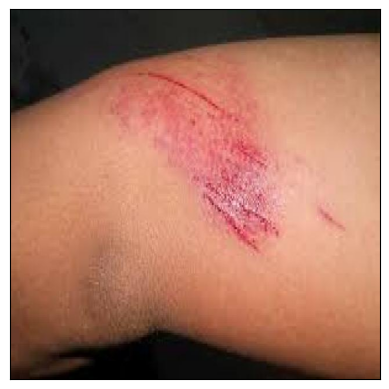

In [ ]:
from PIL import Image
img_path = ('/content/drive/MyDrive/COLAB/DATASETS/Raphina AI/Wound_Data/Test/Abrasions/abrasions (83).jpg')
image = Image.open(img_path).convert('RGB')

xs = np.array(image)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(xs)

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
image_tensor = test_transforms(image)

loaded_model.eval()
with torch.no_grad():
    output = loaded_model(image_tensor.unsqueeze(0).cuda())
    prediction = output.argmax(1).item()

print('Predicted class:', class_n[prediction])

## Transfer Learning

### Data Preparation

In [ ]:
path = "/content/drive/MyDrive/COLAB/DATASETS/Raphina AI/Wound_Data"

In [ ]:
def create_labels_csv_file(dataset_path: str) -> None:
    class_names = []
    for folder_name in os.listdir(dataset_path):
        class_names.append(folder_name)

    image_paths = []
    labels = []

    for i in range(len(class_names)):
        class_name = class_names[i]
        if '.csv' in os.path.basename(class_name):
            continue
        image_names = os.listdir(
            os.path.join(
                dataset_path,
                class_name
            )
        )
        for image_name in image_names:
            image_path = os.path.join(
                dataset_path,
                class_name,
                image_name
            )
            image_paths.append(image_path)
            labels.append(class_name)

    df = pd.DataFrame(
        {
            'name': image_paths,
            'label': labels
        }
    )

    df.to_csv(
        path_or_buf=os.path.join(
            dataset_path,
            'labels.csv'
        ),
        index=False
    )

In [ ]:
create_labels_csv_file(dataset_path = os.path.join(path, 'Train'))
create_labels_csv_file(dataset_path = os.path.join(path, 'Valid'))

In [ ]:
dls = ImageDataLoaders.from_folder(path = path, train = 'Train', valid = 'Valid', item_tfms = Resize(224),
                                   bs = 32, batch_tfms = [Normalize.from_stats(*imagenet_stats), RandTransform()])

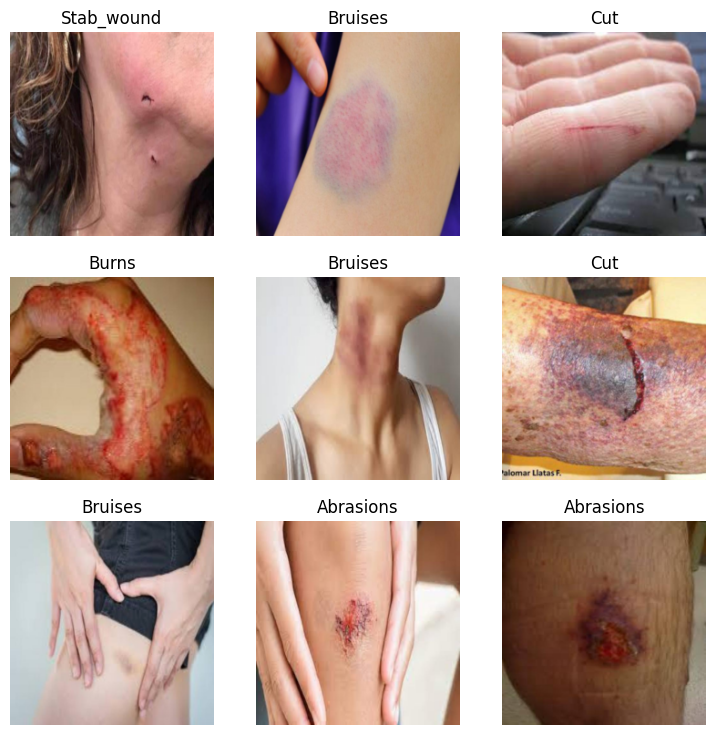

In [ ]:
dls.train.show_batch()

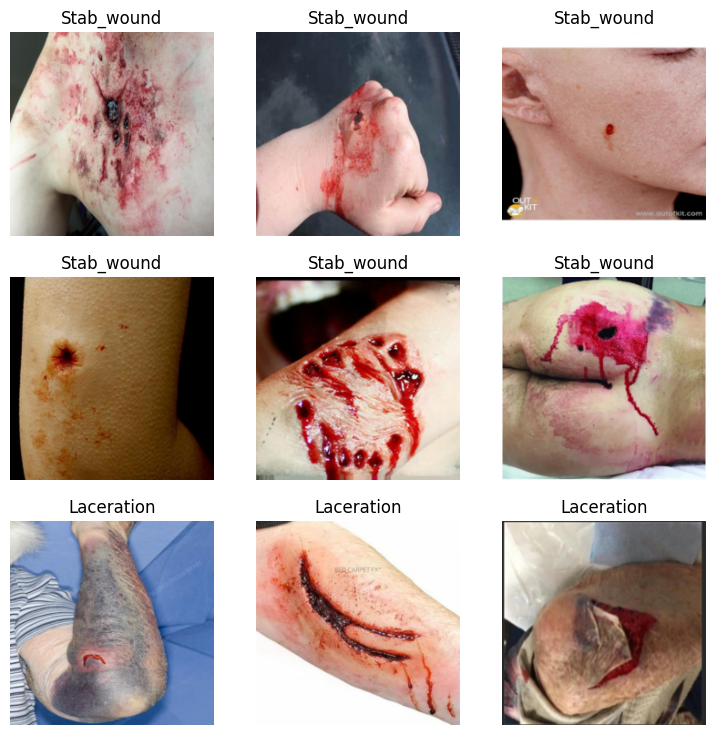

In [ ]:
dls.valid.show_batch()

### ResNet

In [ ]:
resnet = vision_learner(dls = dls, arch = models.resnet101, metrics = accuracy)

In [ ]:
resnet.lr_find()
# model.recorder.plot(suggestions=True)

In [ ]:
resnet.fit_one_cycle(50, 1e-3)

In [ ]:
resnet.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(resnet)
interp.plot_confusion_matrix()

### DenseNet

In [ ]:
densenet = vision_learner(dls = dls, arch = models.densenet201, metrics = [accuracy, error_rate])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0006918309954926372)

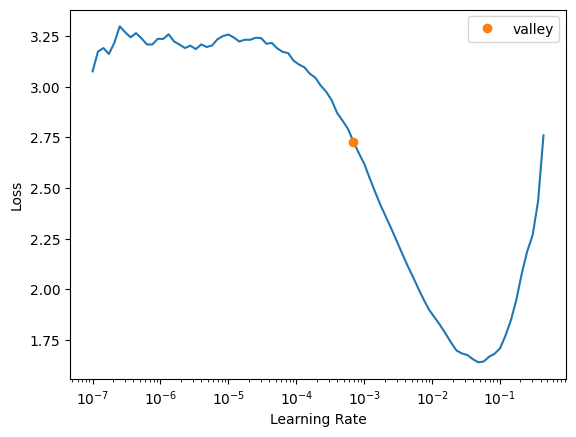

In [ ]:
densenet.lr_find()

In [ ]:
densenet.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.952726,1.937085,0.264706,0.735294,00:07
1,2.413177,1.493741,0.441176,0.558824,00:06
2,1.821983,1.055174,0.617647,0.382353,00:07
3,1.316510,0.897847,0.691176,0.308824,00:06
4,0.977617,0.848888,0.750000,0.250000,00:06
5,0.756460,0.779446,0.779412,0.220588,00:07
6,0.590207,0.833924,0.705882,0.294118,00:07
7,0.463472,0.883952,0.691176,0.308824,00:07
8,0.370977,0.795867,0.705882,0.294118,00:07
9,0.304102,0.813319,0.735294,0.264706,00:07


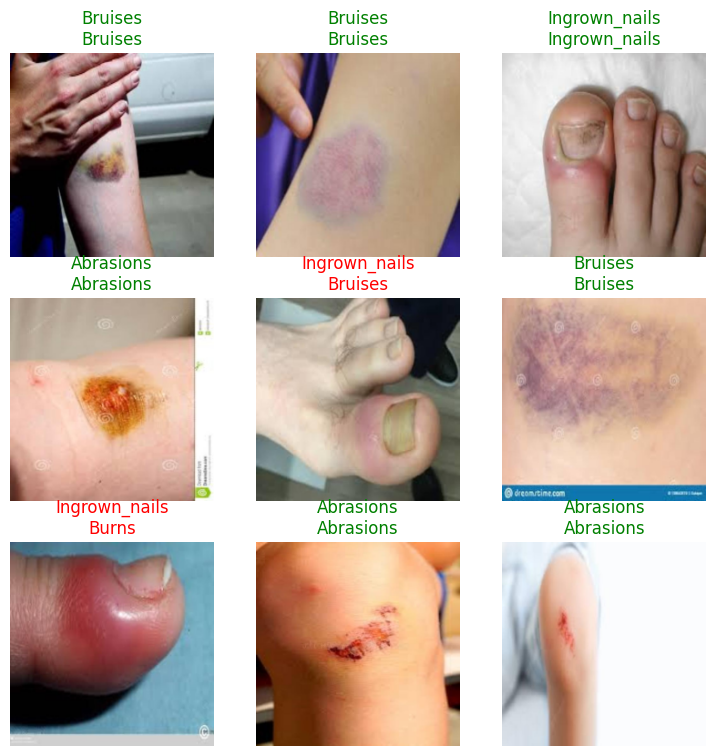

In [ ]:
densenet.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(densenet)

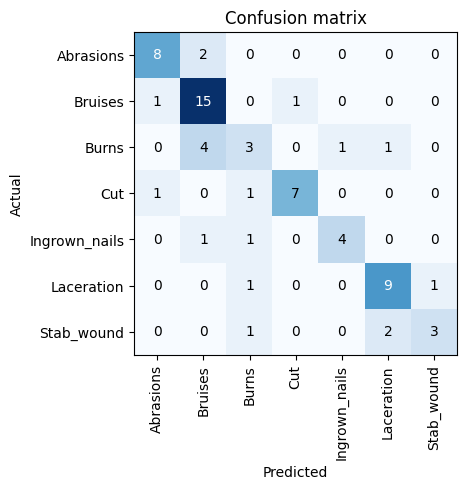

In [ ]:
interp.plot_confusion_matrix()

## Save Model

In [ ]:
densenet.export('models/densenet_wound_classifier.pkl')

## Prediction

In [ ]:
def predict(img_path, model_):

  #get image
  img = Image.open(img_path)
  xs = np.array(img)

  # display image
  ax = plt.gca()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.imshow(xs)

  # get predictions
  pred = model_.predict(xs)
  confidence_level = np.round(float(pred[2].max() * 100), 2)
  result = 'This wound is ' + pred[0] + ', with a confidence level of ' + str(confidence_level) + '%'
  return result

'This wound is Bruises, with a confidence level of 95.96%'

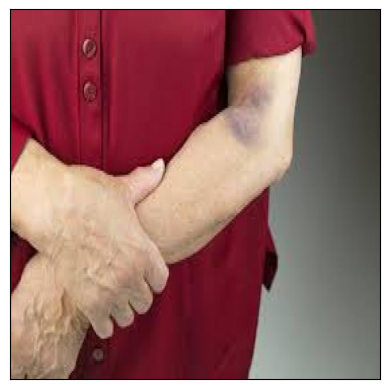

In [ ]:
path = "/content/drive/MyDrive/COLAB/DATASETS/Raphina AI/Wound_Data"
model = load_learner(path + '/models/densenet_wound_classifier.pkl')
img_path = '/content/drive/MyDrive/COLAB/DATASETS/Raphina AI/Wound_Data/Test/Bruises/bruises (121).jpg'
predict(img_path, model)